In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 31.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Node Classification with Graph Neural Networks

[Pytorch Geometric official tutorials](https://pytorch-geometric.readthedocs.io/en/2.6.1/get_started/colabs.html#official-examples)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [3]:
data = dataset[0]  # Get the first graph object.


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [5]:
### To do it with your own data: x is the feature matrix, edge_index is the edgelist
#data = Data(x=x, edge_index=edge_index, ...)


In [6]:
# Quick overview
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
# How many words in a document?
(data.x[0,:]>0).sum()

tensor(9)

In [9]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [10]:
pd.Series(data.y).value_counts()

,count
3,818
4,426
2,418
0,351
5,298
1,217
6,180


We compute coordinates for the nodes with NetworkX. In large networks (>1000 nodes) drawing edges can slow down significantly the plot, so we extract the coordinates and plot them with Matplotlib.

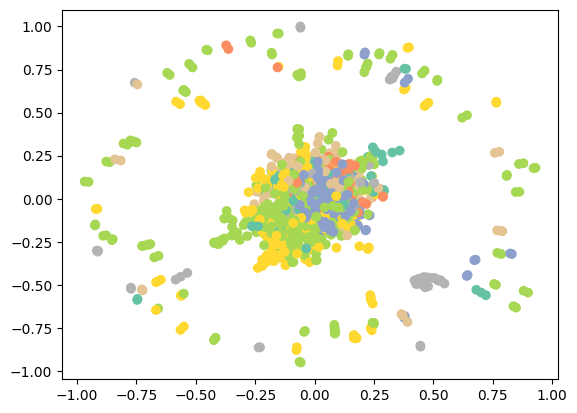

In [11]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

pos= nx.spring_layout(G)
xcoord= [coord[0] for coord in pos.values()]
ycoord= [coord[1] for coord in pos.values()]
plt.scatter(xcoord,ycoord, c=data.y,cmap='Set2')

## Non-graph Neural Network (Multi Layer Perceptron)
Classification using only node features, without using the graph information at all.

In [12]:
from torch.nn import Linear, Dropout
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_node_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)
print('N. of weights:',sum(p.numel() for p in model.parameters()))

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
N. of weights: 23063


In [13]:
model(data.x)

tensor([[-0.0157,  0.2271, -0.0321,  ..., -0.2341,  0.2338,  0.0956],
        [-0.0156,  0.2253, -0.0326,  ..., -0.2335,  0.2386,  0.0970],
        [-0.0087,  0.2283, -0.0308,  ..., -0.2315,  0.2397,  0.1078],
        ...,
        [-0.0103,  0.2253, -0.0287,  ..., -0.2292,  0.2368,  0.0949],
        [-0.0142,  0.2204, -0.0237,  ..., -0.2323,  0.2374,  0.0989],
        [-0.0198,  0.2274, -0.0354,  ..., -0.2350,  0.2368,  0.1075]],
       grad_fn=<AddmmBackward0>)

In [14]:
from torch import softmax
softmax(model(data.x),1)#.sum(1)

tensor([[0.1375, 0.1752, 0.1352,  ..., 0.1096, 0.1771, 0.1544],
        [0.1379, 0.1748, 0.1349,  ..., 0.1101, 0.1768, 0.1545],
        [0.1366, 0.1752, 0.1341,  ..., 0.1106, 0.1766, 0.1557],
        ...,
        [0.1365, 0.1759, 0.1340,  ..., 0.1102, 0.1768, 0.1552],
        [0.1374, 0.1749, 0.1344,  ..., 0.1105, 0.1763, 0.1555],
        [0.1378, 0.1747, 0.1352,  ..., 0.1101, 0.1773, 0.1534]],
       grad_fn=<SoftmaxBackward0>)

In [15]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss



for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9611
Epoch: 002, Loss: 1.9541
Epoch: 003, Loss: 1.9454
Epoch: 004, Loss: 1.9388
Epoch: 005, Loss: 1.9290
Epoch: 006, Loss: 1.9182
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8970
Epoch: 009, Loss: 1.8854
Epoch: 010, Loss: 1.8681
Epoch: 011, Loss: 1.8560
Epoch: 012, Loss: 1.8438
Epoch: 013, Loss: 1.8274
Epoch: 014, Loss: 1.8085
Epoch: 015, Loss: 1.7921
Epoch: 016, Loss: 1.7743
Epoch: 017, Loss: 1.7614
Epoch: 018, Loss: 1.7431
Epoch: 019, Loss: 1.7165
Epoch: 020, Loss: 1.7061
Epoch: 021, Loss: 1.6646
Epoch: 022, Loss: 1.6462
Epoch: 023, Loss: 1.6253
Epoch: 024, Loss: 1.5866
Epoch: 025, Loss: 1.5588
Epoch: 026, Loss: 1.5437
Epoch: 027, Loss: 1.5247
Epoch: 028, Loss: 1.4933
Epoch: 029, Loss: 1.4656
Epoch: 030, Loss: 1.4379
Epoch: 031, Loss: 1.4122
Epoch: 032, Loss: 1.3717
Epoch: 033, Loss: 1.3534
Epoch: 034, Loss: 1.3139
Epoch: 035, Loss: 1.2895
Epoch: 036, Loss: 1.2505
Epoch: 037, Loss: 1.2159
Epoch: 038, Loss: 1.2074
Epoch: 039, Loss: 1.1489
Epoch: 040, Loss: 1.1115


### Evaluate on test set

In [16]:
model.eval()
out = model(data.x)
pred = out.argmax(dim=1)  # Use the class with highest probability.

train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
print(f'Training set accuracy:{train_acc:.3f}')

test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
print(f'Test set accuracy:{test_acc:.3f}')


Training set accuracy:1.000
Test set accuracy:0.525


## Convolutional GNN

In [49]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)
print('N. of weights:',sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
N. of weights: 23063


In [50]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss



for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9464
Epoch: 002, Loss: 1.9386
Epoch: 003, Loss: 1.9313
Epoch: 004, Loss: 1.9232
Epoch: 005, Loss: 1.9136
Epoch: 006, Loss: 1.9027
Epoch: 007, Loss: 1.8922
Epoch: 008, Loss: 1.8821
Epoch: 009, Loss: 1.8700
Epoch: 010, Loss: 1.8578
Epoch: 011, Loss: 1.8436
Epoch: 012, Loss: 1.8320
Epoch: 013, Loss: 1.8135
Epoch: 014, Loss: 1.8030
Epoch: 015, Loss: 1.7905
Epoch: 016, Loss: 1.7734
Epoch: 017, Loss: 1.7562
Epoch: 018, Loss: 1.7405
Epoch: 019, Loss: 1.7300
Epoch: 020, Loss: 1.7065
Epoch: 021, Loss: 1.6913
Epoch: 022, Loss: 1.6766
Epoch: 023, Loss: 1.6576
Epoch: 024, Loss: 1.6310
Epoch: 025, Loss: 1.6183
Epoch: 026, Loss: 1.6009
Epoch: 027, Loss: 1.5764
Epoch: 028, Loss: 1.5525
Epoch: 029, Loss: 1.5323
Epoch: 030, Loss: 1.5200
Epoch: 031, Loss: 1.4933
Epoch: 032, Loss: 1.4741
Epoch: 033, Loss: 1.4599
Epoch: 034, Loss: 1.4293
Epoch: 035, Loss: 1.3984
Epoch: 036, Loss: 1.3633
Epoch: 037, Loss: 1.3737
Epoch: 038, Loss: 1.3404
Epoch: 039, Loss: 1.3125
Epoch: 040, Loss: 1.2836


### Evaluate on test set

In [51]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
print(f'Training set accuracy:{train_acc:.3f}')

test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
print(f'Test set accuracy:{test_acc:.3f}')


Training set accuracy:1.000
Test set accuracy:0.811


### Visualization of the logits (supervised)

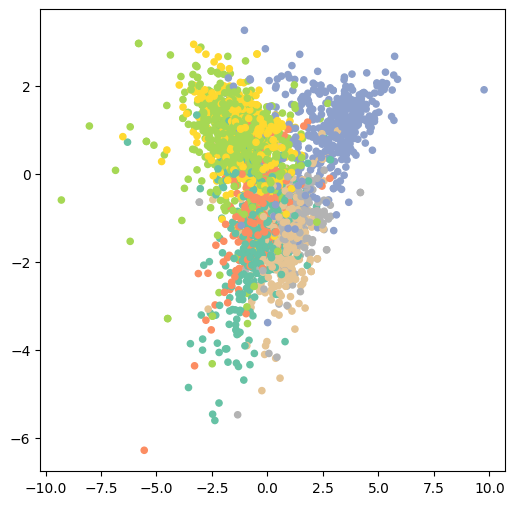

In [52]:
logits= model(data.x,data.edge_index).detach().cpu().numpy()
z= PCA(2).fit_transform(logits)

plt.figure(figsize=(6,6))
plt.scatter(z[:, 0], z[:, 1], s=20, c=data.y, cmap="Set2")
plt.show()

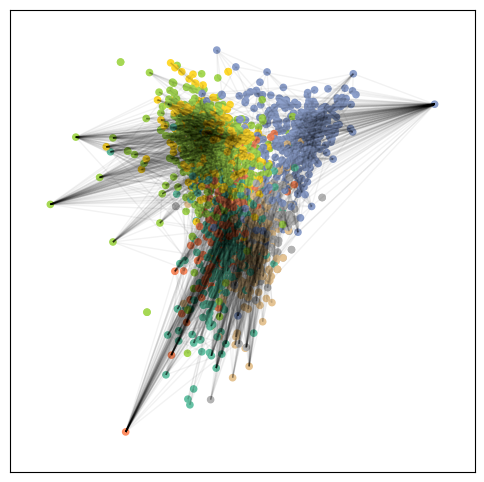

In [53]:
# With edges
logits= model(data.x,data.edge_index).detach().cpu().numpy()
z= PCA(2).fit_transform(logits)
supervised_pos={i: (z[i,0],z[i,1]) for i in range(len(data.x))}

plt.figure(figsize=(6,6))
plt.scatter(z[:, 0], z[:, 1], s=20, c=data.y, cmap="Set2")
nx.draw_networkx_edges(G,supervised_pos,alpha=.05)
plt.show()

## Node classification without network features
When only the network is available, without any feature at node level.

Workaround: a one-hot encoding for each node (identity matrix).

In [54]:
data = dataset[0]
data.x = torch.eye(data.num_nodes)

model = GCN(16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 020, Loss: 1.2381
Epoch: 040, Loss: 0.4575
Epoch: 060, Loss: 0.2276
Epoch: 080, Loss: 0.1567
Epoch: 100, Loss: 0.1393
Epoch: 120, Loss: 0.1292
Epoch: 140, Loss: 0.1078
Epoch: 160, Loss: 0.1083
Epoch: 180, Loss: 0.0876
Epoch: 200, Loss: 0.0910


In [55]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
print(f'Training set accuracy:{train_acc:.3f}')

test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
print(f'Test set accuracy:{test_acc:.3f}')


Training set accuracy:1.000
Test set accuracy:0.654


# Node embeddings
Here we generalize the approach to the case when no label are provided at node level, hence we aim to build *unsupervised* or better *self-supervised* node represenations.

We will build a loss function grounded on *contrastive learning*, which mean to learn by showing the GNN pairs of *positive* and *negative* pairs of nodes. A positive pair is composed by two connected nodes, while a negative pair is composed by two nodes without an edge between them.

The loss function aims to maximize the proximity of connected nodes in the embedding space (positive pairs) and minimize the proximity of negative pairs (random sampling them).


![image info](./figures/pos_neg_loss.png "Contrastive loss")

In [4]:
data = dataset[0]
data.edge_index.shape

torch.Size([2, 10556])

In [14]:
data.edge_index[:,:10]

tensor([[ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666],
        [   0,    0,    0,    1,    1,    1,    2,    2,    2,    2]])

In [20]:
# If this does not raise an error, it means the edge exists
G.edges[633,0]

{}

In [6]:
from torch_geometric.utils import negative_sampling
negative_sampling(data.edge_index).shape

torch.Size([2, 10556])

In [10]:
negative_sampling(data.edge_index)[:,:10]

tensor([[1916, 1340,   56, 1051, 2355, 2267,  915,  956, 1218,  364],
        [2517, 1168,  563,  686,  284,  434, 1294, 2380, 1372, 2123]])

In [18]:
# If this raises a KeyError, it means the edge does not exist
G.edges[1916,2517]

KeyError: 'The edge (1916, 2517) is not in the graph.'

In [21]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_size):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, embedding_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GraphSAGE(data.num_features, 16, 7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def loss_fn(z, edge_index):
    # Positive pairs
    pos_loss = -torch.log(torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))).mean()

    # Negative sampling
    neg_edge_index = negative_sampling(edge_index, num_nodes=z.size(0))
    neg_loss = -torch.log(1 - torch.sigmoid((z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1))).mean()

    return pos_loss + neg_loss

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    # This time we also encode the node features in the embedding
    embeddings = model(data.x, data.edge_index)
    loss = loss_fn(z, data.edge_index)
    loss.backward()
    optimizer.step()
    if epoch%20==0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print("Node embeddings shape:", embeddings.shape)

Epoch: 000, Loss: 1.3926
Epoch: 020, Loss: 1.2470
Epoch: 040, Loss: 1.1604
Epoch: 060, Loss: 1.1304
Epoch: 080, Loss: 1.0960
Epoch: 100, Loss: 1.0364
Epoch: 120, Loss: 1.0176
Epoch: 140, Loss: 1.0024
Epoch: 160, Loss: 0.9947
Epoch: 180, Loss: 0.9701
Node embeddings shape: torch.Size([2708, 7])


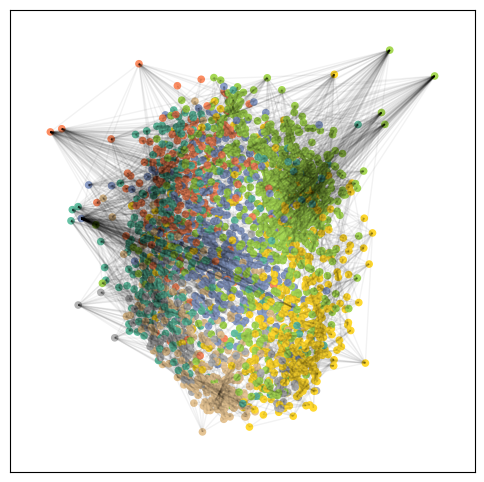

In [25]:
# With edges
z= PCA(2).fit_transform(embeddings.detach().cpu().numpy())
self_supervised_pos={i: (z[i,0],z[i,1]) for i in range(len(data.x))}

plt.figure(figsize=(6,6))
plt.scatter(z[:, 0], z[:, 1], s=20, c=data.y, cmap="Set2")
nx.draw_networkx_edges(G,self_supervised_pos,alpha=.05)
plt.show()